In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import NearestNeighbors
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from sklearn.cluster import DBSCAN

In [3]:
!curl -L -O https://github.com/ml-clustering-proj/wholesale-clustering/raw/main/data/Wholesale_customers_data.csv
df = pd.read_csv('Wholesale_customers_data.csv')
print(df.shape)
print(df.ndim)
print(df.columns)
df.head()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 14580  100 14580    0     0  22057      0 --:--:-- --:--:-- --:--:-- 22057
(440, 8)
2
Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


## Density of Dataset

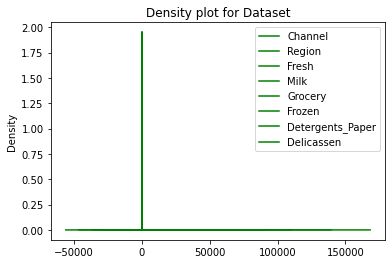

In [5]:
df.plot.density(color='green')
plt.title('Density plot for Dataset')
plt.show()

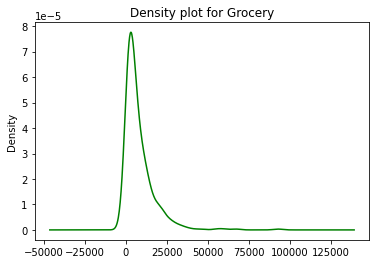

In [6]:
df.Grocery.plot.density(color='green')
plt.title('Density plot for Grocery')
plt.show()

# Data Preprocessing

In [7]:
num_col = ["Fresh",	"Milk"	,"Grocery", "Frozen", "Detergents_Paper",	"Delicassen"]
cate_col = ["Channel", "Region"]

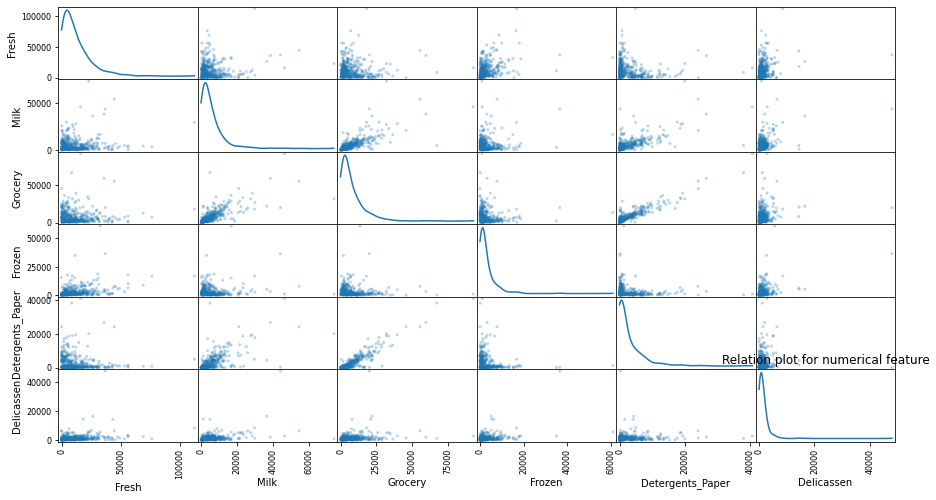

In [8]:
pd.plotting.scatter_matrix(df[num_col], alpha=0.3,figsize=(15,8),diagonal='kde' )
plt.title('Relation plot for numerical feature')
plt.show()

- The pairs Milk-Grocery , Grocery-Detergents_Paper and Detergents_Paper-Milk show negative correlation. And the rest of the pairs show some degree of positive correlation.
- For the feature selected above (Grocery) shows some degree of positive correlation with all the other features(except Milk and Detergents_Paper). This confirms the suspicions to some extent about the relevance of the feature which I tried to predict, since Grocery shows a correlation with other features except Milk and Detergents_Paper.

Remove Outlier, IQR

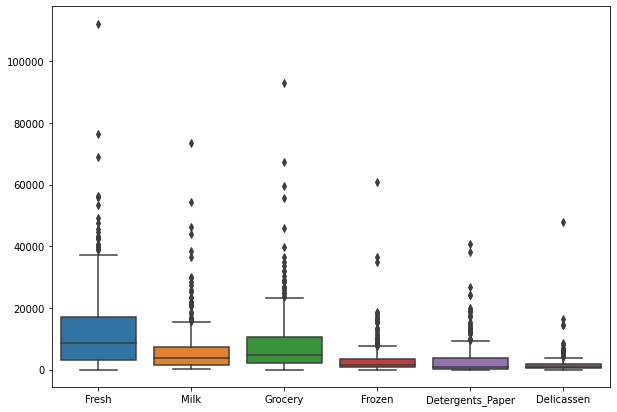

In [9]:
plt.figure(figsize=(10,7))
sns.boxplot(data=df[num_col])
plt.show()

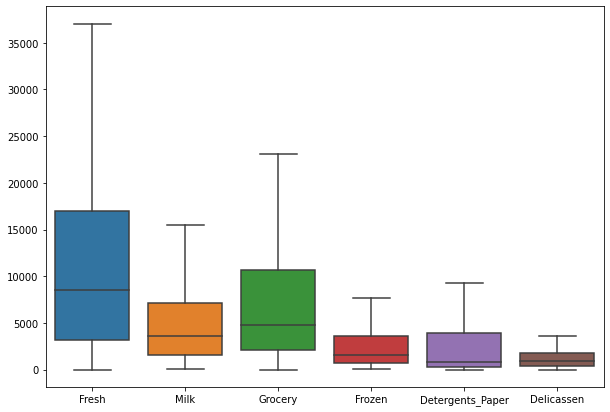

In [10]:
iqr_df = df[num_col].copy()

for col in iqr_df.columns:
  q25 = iqr_df[col].quantile(0.25)
  q50 = iqr_df[col].quantile(0.5)
  q75 = iqr_df[col].quantile(0.75)
  iqr=q75-q25

  iqr_df.loc[iqr_df[col] > q75 + 1.5 * iqr, col] = q75
  iqr_df.loc[iqr_df[col] < q25 - 1.5 * iqr, col] = q25

plt.figure(figsize=(10,7))
sns.boxplot(data=iqr_df)
plt.show()

Data Normalization

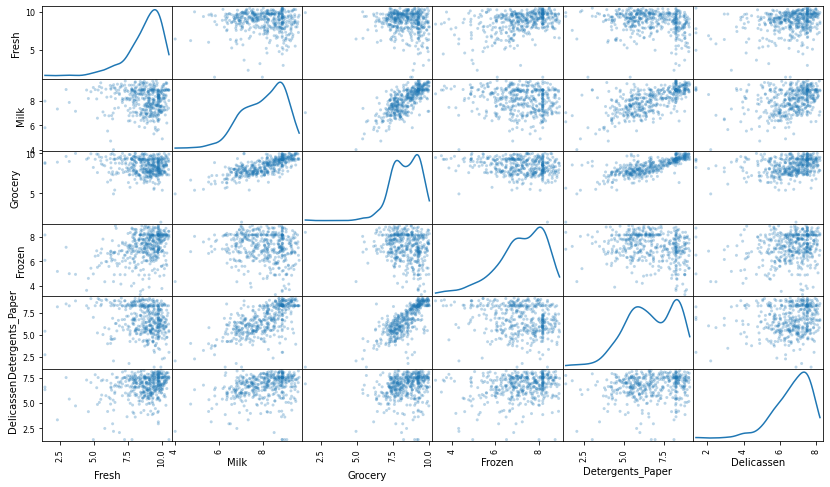

In [11]:
# Scale the data using the natural logarithm
log_data = np.log1p(iqr_df)

pd.plotting.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [12]:
# Scale the data using MinMaxScaler
normalizer = MinMaxScaler()
normalized_df = pd.DataFrame(
    data = normalizer.fit_transform(log_data),
    columns = log_data.columns
    )

print(normalized_df.head())

      Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen
0  0.882554  0.915973  0.870949  0.371351          0.839645    0.853291
1  0.818495  0.918786  0.898122  0.741224          0.866511    0.894831
2  0.806990  0.899626  0.872811  0.795884          0.874966    0.898441
3  0.887587  0.544634  0.803667  0.967997          0.625233    0.895819
4  0.945994  0.812950  0.865270  0.881509          0.786925    0.898441


In [13]:
normalized_df.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,0.798993,0.714377,0.807239,0.690291,0.685688,0.764149
std,0.155055,0.171560,0.118058,0.197329,0.204120,0.174746
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.729422,0.588753,0.725978,0.589391,0.537661,0.679304
50%,0.838913,0.741851,0.817428,0.715959,0.686639,0.805441
75%,0.914316,0.863422,0.910472,0.864326,0.888745,0.898365
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Reduce dimension using PCA

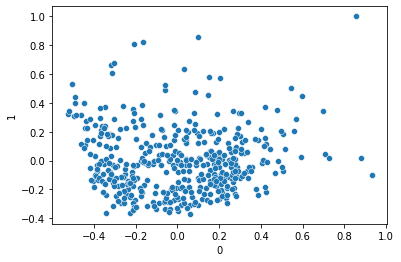

In [14]:
pca = PCA(n_components=2)
reduced_df = pd.DataFrame(pca.fit_transform(normalized_df), columns=[0, 1])
sns.scatterplot(reduced_df[0], reduced_df[1], legend="full")
plt.show()

# Find Hyper Parameter

min_sample:  7


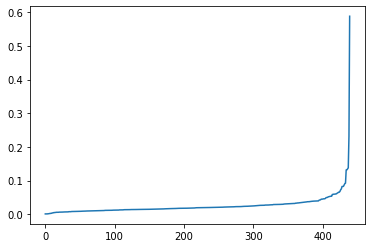

In [15]:
min_sample = int(np.ceil(np.log(reduced_df .shape[0])))
print('min_sample: ',min_sample)

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(reduced_df)
distances, indices = nbrs.kneighbors(reduced_df)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

# Run DBScan

In [16]:
def iterable_DBscan(data, min_eps, max_eps, eps_gap, min_sample):
  i = min_eps

  while i <= max_eps:
    db = DBSCAN(eps=i, min_samples=min_sample)
    cluster = db.fit(data)
    cluster_id = pd.DataFrame({"cluster":cluster.labels_})

    # for plot
    p = PCA(n_components=2)
    df_p = pd.DataFrame(p.fit_transform(data), columns=[0, 1])
    sns.scatterplot(df_p[0], df_p[1], hue = cluster.labels_, legend="full")
    plt.title('DBScan with eps {}'.format(i))
    plt.show()

    # evaluate
    try:
      print('Silhouette Coefficient: {:.4f}'.format(silhouette_score(data, cluster_id)))
      print('Davies Bouldin Index: {:.4f}'.format(davies_bouldin_score(data, cluster_id)))  
    except Exception as e:
      print('평가지표 계산 중 에러가 발생했습니다.\n', e)
    print('---------------------\n\n\n')

    i += eps_gap

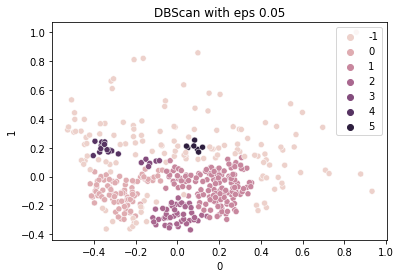

Silhouette Coefficient: 0.0481
Davies Bouldin Index: 3.1810
---------------------





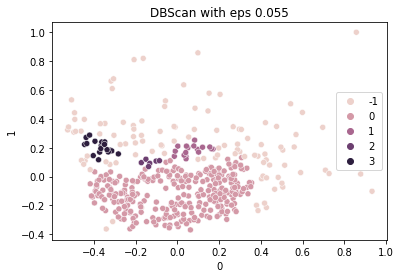

Silhouette Coefficient: -0.0874
Davies Bouldin Index: 4.3115
---------------------





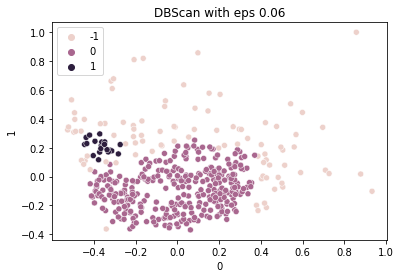

Silhouette Coefficient: 0.1860
Davies Bouldin Index: 1.5896
---------------------





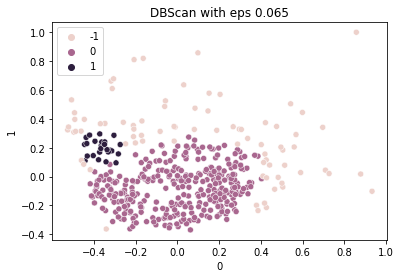

Silhouette Coefficient: 0.2006
Davies Bouldin Index: 1.5730
---------------------





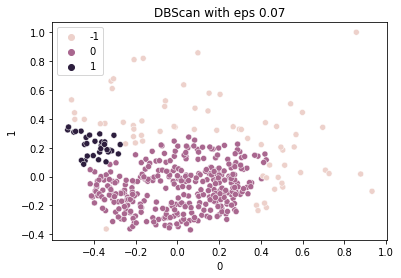

Silhouette Coefficient: 0.2413
Davies Bouldin Index: 1.4309
---------------------





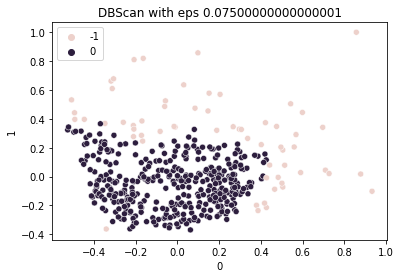

Silhouette Coefficient: 0.3650
Davies Bouldin Index: 1.7354
---------------------





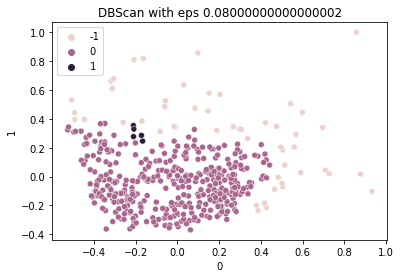

Silhouette Coefficient: 0.1084
Davies Bouldin Index: 1.4182
---------------------





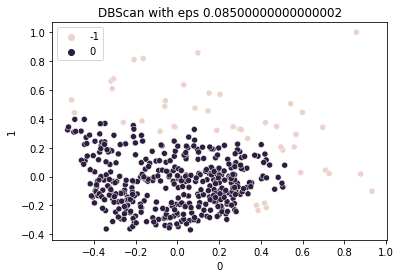

Silhouette Coefficient: 0.3950
Davies Bouldin Index: 1.4752
---------------------





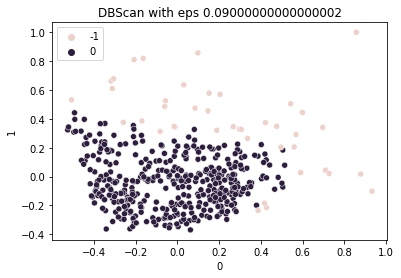

Silhouette Coefficient: 0.3987
Davies Bouldin Index: 1.4139
---------------------





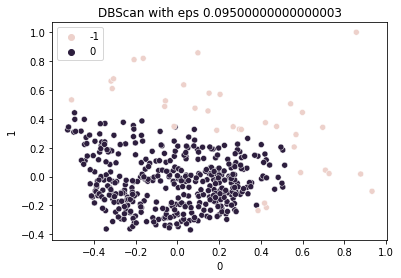

Silhouette Coefficient: 0.4166
Davies Bouldin Index: 1.3856
---------------------





In [17]:
min_eps = 0.05
max_eps = 0.1
eps_gap = 0.005

iterable_DBscan(reduced_df, min_eps, max_eps, eps_gap, min_sample)